In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import numpy as np
import math
import jax
import jax.numpy as jnp
import os
import pickle
import jax
import math
from flax.training import checkpoints
import matplotlib.pyplot as plt
from utils.tools_1 import make_library_functions

from models.models_1.model_1_nl_time_lat_lon_CAE import (
    ConcreteAutoencoder,
    create_train_state,
    train_for_epochs,
)

num_epochs = 1000
initial_lr = 5e-3
min_temp = 0.01
start_temp = 10.

with open("../data/u_10m_comp_vals_3.pkl", 'rb') as f:
    loaded_data = pickle.load(f)

# dict_keys(['lat_vals', 'lon_vals', 'train', 'test', 'val', 'U_vals', 'sing_vals', 'Vt_vals', 'r95'])

S_train = loaded_data['train']['data']
train_times = loaded_data['train']['time']

S_test = loaded_data['test']['data']
test_times = loaded_data['test']['time']

S_val = loaded_data['val']['data']
val_times = loaded_data['val']['time']

lat_vals = loaded_data['lat_vals']
lon_vals = loaded_data['lon_vals']

lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals, indexing="xy")
global_coords = np.stack([lon_grid.ravel(), lat_grid.ravel()], axis=1)  # (Nh,2)

r_val = loaded_data['r95']
batch_size = max(S_train.shape[1] // 256, 256)

# print(S_train.shape[1], batch_size) # 128
 
Nh_val = S_train.shape[0]
r_val = 20

steps_per_epoch = (S_train.shape[1] + batch_size - 1) // batch_size
alpha_const = math.exp(math.log(min_temp / start_temp) / (num_epochs * steps_per_epoch))

rng = jax.random.PRNGKey(0)
model = ConcreteAutoencoder(
    min_temp     = min_temp,
    start_temp   = start_temp,
    alpha_const  = alpha_const,
    global_coords= jnp.array(global_coords),
    enc_inp_dim  = Nh_val,
    enc_out_dim  = r_val,
    frac_dynamics= 0.5
)

restored_state = create_train_state(
    rng,
    model,
    input_shape=(batch_size, Nh_val),
    lr=initial_lr,
)

results_dir = f'/workspace/venu_files/climate_forecasting/CAE_transf/results/ne{num_epochs}_bs{batch_size}_lr{initial_lr}_Nval{Nh_val}_rval{r_val}_m2/'
os.makedirs(f"{results_dir}", exist_ok=True)

CKPT_DIR = f"{results_dir}checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)

restored_state = checkpoints.restore_checkpoint(
    ckpt_dir=CKPT_DIR,
    target=restored_state       # will be replaced with the latest checkpoint
)

# results:
# 1. test data predictions comparison:

from models.models_1.model_1_nl_time_lat_lon_CAE import (
    Dff_Network,
    Decoder
)

from utils.timefeatures import time_features
import pandas as pd

with open(results_dir + "final_results.pkl", "rb") as file:
    final_results = pickle.load(file)

preserved_grads = final_results['preserved_grads']
train_loss_hist = final_results['train_loss_hist']
val_loss_hist = final_results['val_loss_hist']
mean_max_prob = final_results['mean_max_prob']
logit_vals_hist = final_results['logit_vals_hist']
best_train_loss = final_results['best_train_loss']
best_val_loss = final_results['best_val_loss']

best_logits_spt = logit_vals_hist[np.argmin(val_loss_hist)]
selected_indices_spt = jnp.argmax(best_logits_spt, axis=1)

dff_params =     restored_state.params['dff_network']
decoder_params = restored_state.params['decoder']

selected_coords = global_coords[selected_indices_spt]

2025-07-29 11:10:30.156732: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-07-29 11:10:30.210356: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-29 11:10:31.221837: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-07-29 11:10:31.221948: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2025-07-29 11:10:31.221956: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Ca

In [3]:
print( len(logit_vals_hist))
best_logits = logit_vals_hist[np.argmin(val_loss_hist)]
selected_indices = jnp.argmax(best_logits, axis=1)

S_test_t = S_test.T

test_times_pd = pd.to_datetime(test_times)
test_times_enc = time_features(test_times_pd, freq='h')
test_times_enc = test_times_enc.T

test_times_expanded = jnp.broadcast_to(test_times_enc[:, None, :], (S_test_t.shape[0], r_val, 4))

coords_expanded = jnp.broadcast_to(selected_coords[None, ...], (S_test_t.shape[0], r_val, 2))
test_dff_input = jnp.concatenate([test_times_expanded, coords_expanded], axis=-1)

encoder_input_dim = Nh_val
encoder_output_dim = r_val

dff_network_module_tester = Dff_Network(input_dim=6, output_dim=1)
Decoder_module_tester = Decoder(input_dim=encoder_output_dim, output_dim=encoder_input_dim)

test_dff_output = dff_network_module_tester.apply(
    {'params': dff_params},
    test_dff_input,
    deterministic=True,
    mutable=False
)[..., 0]

test_preds = Decoder_module_tester.apply(
    {'params': decoder_params},
    test_dff_output,
    deterministic=True,
    mutable=False
)

S_test_pred = test_preds.T

1000


In [4]:
print(S_test.shape, S_test_pred.shape)

(22701, 868) (22701, 868)


In [5]:
preserved_grads = final_results['preserved_grads']

# print(preserved_grads[0].keys()) # dict_keys(['decoder', 'dff_network', 'encoder'])

# stacked = jax.tree.map(lambda *xs: jnp.stack(xs, axis=0), *preserved_grads)

In [6]:
print(preserved_grads[0].keys()) # dict_keys(['decoder', 'dff_network', 'encoder'])
print(preserved_grads[0]['decoder'].keys()) # dict_keys(['Dense_0', 'Dense_1', 'Dense_2'])
print(preserved_grads[0]['decoder']['Dense_0'].keys()) # dict_keys(['bias', 'kernel'])
print(preserved_grads[0]['decoder']['Dense_1'].keys()) # dict_keys(['bias', 'kernel'])
print(preserved_grads[0]['decoder']['Dense_2'].keys()) # dict_keys(['bias', 'kernel'])

print(preserved_grads[0]['dff_network'].keys()) # dict_keys(['Dense_0', 'Dense_1', 'Dense_2'])
print(preserved_grads[0]['dff_network']['Dense_0'].keys()) # dict_keys(['bias', 'kernel'])
print(preserved_grads[0]['dff_network']['Dense_1'].keys()) # dict_keys(['bias', 'kernel'])
print(preserved_grads[0]['dff_network']['Dense_2'].keys()) # dict_keys(['bias', 'kernel'])

print(preserved_grads[0]['encoder'].keys()) # dict_keys(['logits'])
print(preserved_grads[0]['encoder']['logits'].shape) # (20, 22701)

dict_keys(['decoder', 'dff_network', 'encoder'])
dict_keys(['Dense_0', 'Dense_1', 'Dense_2'])
dict_keys(['bias', 'kernel'])
dict_keys(['bias', 'kernel'])
dict_keys(['bias', 'kernel'])
dict_keys(['Dense_0', 'Dense_1', 'Dense_2'])
dict_keys(['bias', 'kernel'])
dict_keys(['bias', 'kernel'])
dict_keys(['bias', 'kernel'])
dict_keys(['logits'])
(20, 22701)


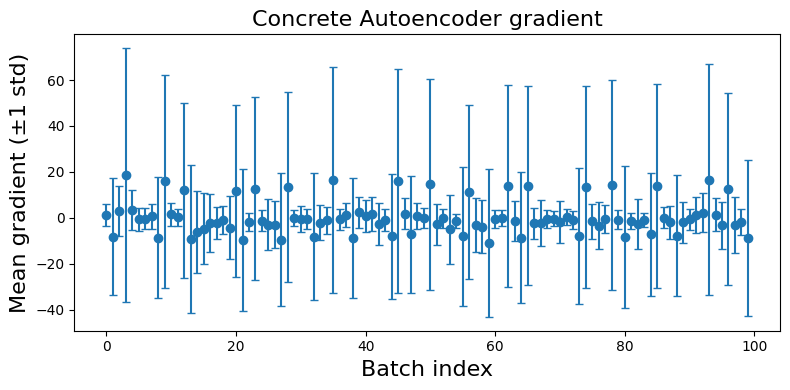

In [13]:
# test_stack = jnp.stack([g['decoder']['Dense_2']['kernel'] for g in preserved_grads])

test_stack = []
for i in range( len(preserved_grads) - 100, len(preserved_grads)):
    # test_stack.append( preserved_grads[i]['encoder']['logits']  )
    test_stack.append( preserved_grads[i]['decoder']['Dense_0']['bias']  )


# print(len(test_stack))
# print(test_stack[0].shape)

# print( len(preserved_grads['decoder']['Dense_2']['kernel'])   )

means = [arr.mean() for arr in test_stack]
stds  = [arr.std()  for arr in test_stack]

all_idxs = np.arange(len(means))
sampled_idxs = all_idxs           # 0, 10, 20, …

# slice your stats to only those points
sampled_means = np.array(means)
sampled_stds  = np.array(stds)

plt.figure(figsize=(8,4))

plt.errorbar(
    sampled_idxs,
    sampled_means,
    yerr=sampled_stds,
    fmt='o',
    capsize=3
)

plt.xlabel('Batch index', fontsize=16)
plt.ylabel('Mean gradient (±1 std)', fontsize=16)
plt.title('Concrete Autoencoder gradient', fontsize=16)
plt.tight_layout()
plt.show()  

In [109]:
print(val_loss_hist)

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


62146.962582981294 : 3890556.6010863003
35783.234 : 1284903.6


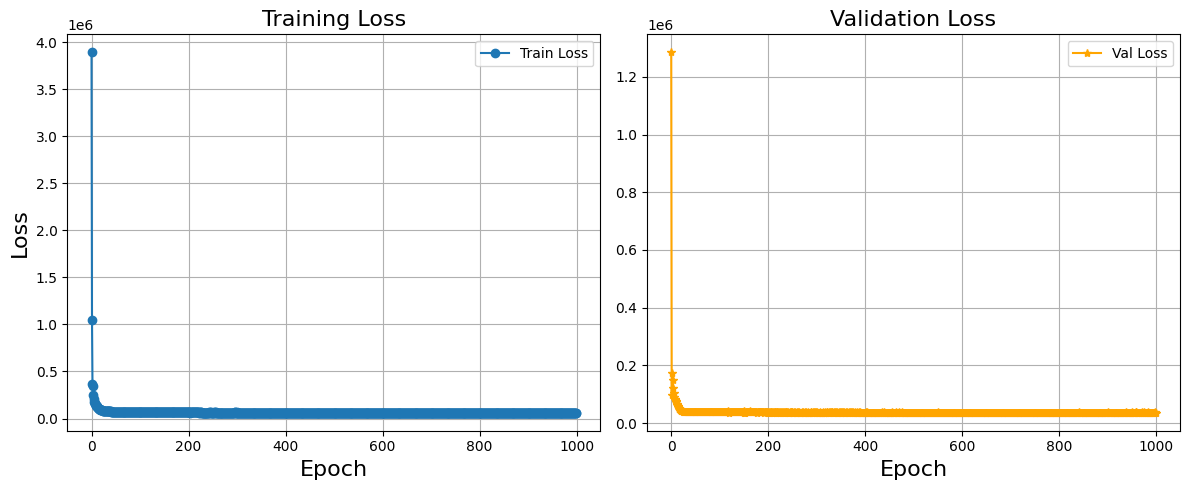

In [8]:
# 2. train and validation loss hist:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: training loss
axes[0].plot(train_loss_hist, marker='o', label='Train Loss')
axes[0].set_title('Training Loss', fontsize = 16)
axes[0].set_xlabel('Epoch', fontsize = 16)
axes[0].set_ylabel('Loss', fontsize = 16)
axes[0].grid(True)
axes[0].legend()

# Right: validation loss
axes[1].plot(val_loss_hist, marker='*', color='orange', label='Val Loss')
axes[1].set_title('Validation Loss', fontsize = 16)
axes[1].set_xlabel('Epoch', fontsize = 16)
axes[1].grid(True)
axes[1].legend()
plt.tight_layout()
plt.savefig(f'{results_dir}testing_validation_loss.png')
# plt.show()

print(np.array(train_loss_hist).min(), ':', np.array(train_loss_hist).max())
print(np.array(val_loss_hist).min(), ':', np.array(val_loss_hist).max())

638
62146.962582981294 : 3890556.6010863003
35783.234 : 1284903.6


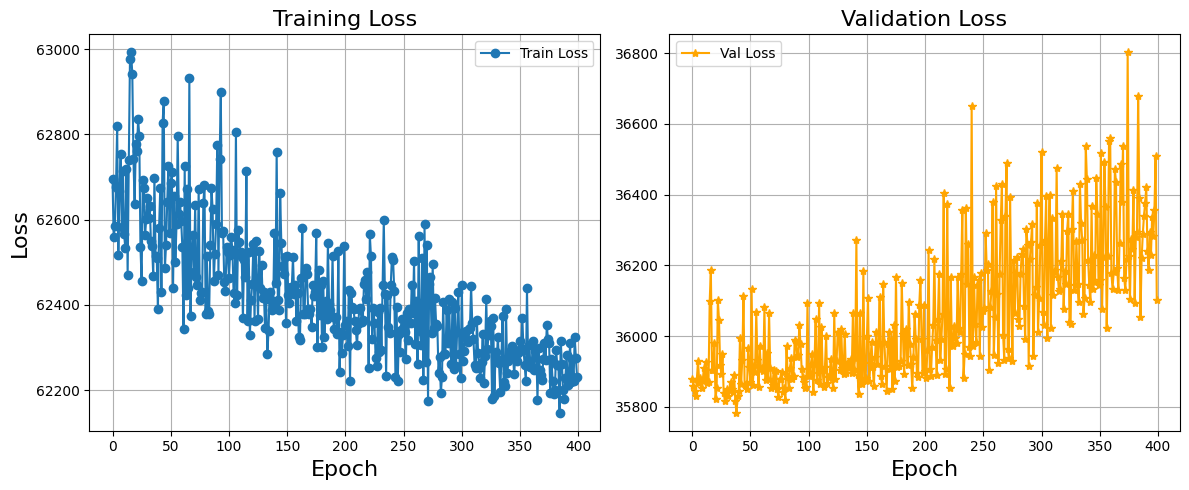

In [10]:
# 2. train and validation loss hist:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: training loss
axes[0].plot(train_loss_hist[-400:], marker='o', label='Train Loss')
axes[0].set_title('Training Loss', fontsize = 16)
axes[0].set_xlabel('Epoch', fontsize = 16)
axes[0].set_ylabel('Loss', fontsize = 16)
axes[0].grid(True)
axes[0].legend()

# Right: validation loss
axes[1].plot(val_loss_hist[-400:], marker='*', color='orange', label='Val Loss')
axes[1].set_title('Validation Loss', fontsize = 16)
axes[1].set_xlabel('Epoch', fontsize = 16)
axes[1].grid(True)
axes[1].legend()
plt.tight_layout()
# plt.savefig(f'{results_dir}testing_validation_loss.png')
# plt.show()

print(np.argmin(val_loss_hist))

print(np.array(train_loss_hist).min(), ':', np.array(train_loss_hist).max())
print(np.array(val_loss_hist).min(), ':', np.array(val_loss_hist).max())

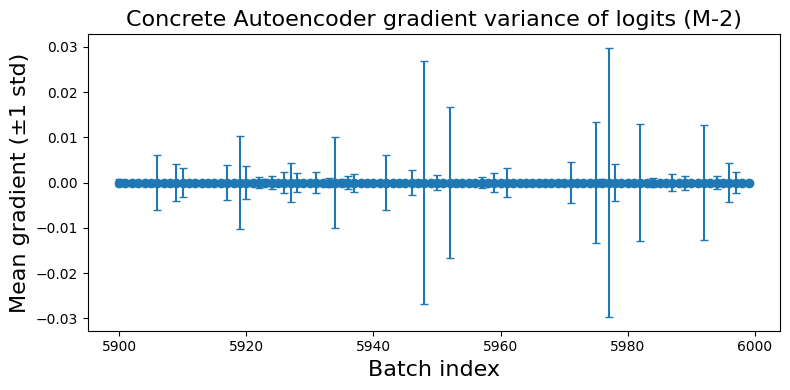

In [54]:
cae_stack = jnp.stack([g['encoder']['logits'] for g in preserved_grads])

means = [arr.mean() for arr in cae_stack]
stds  = [arr.std()  for arr in cae_stack]

all_idxs = np.arange(len(means))
sampled_idxs = all_idxs           # 0, 10, 20, …

# slice your stats to only those points
sampled_means = np.array(means)
sampled_stds  = np.array(stds)

plt.figure(figsize=(8,4))

plt.errorbar(
    sampled_idxs[-100:],
    sampled_means[-100:],
    yerr=sampled_stds[-100:],
    fmt='o',
    capsize=3
)

plt.xlabel('Batch index', fontsize=16)
plt.ylabel('Mean gradient (±1 std)', fontsize=16)
plt.title('Concrete Autoencoder gradient variance of logits (M-2)', fontsize=16)
plt.tight_layout()
plt.show()  


4.527107739704661e-05 : 0.7370598912239075


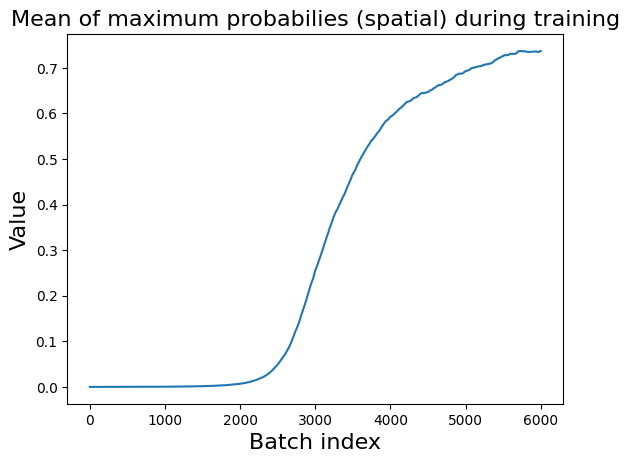

In [11]:
plt.plot(mean_max_prob)
plt.xlabel('Batch index', fontsize = 16)
plt.ylabel('Value', fontsize = 16)
plt.title('Mean of maximum probabilies (spatial) during training', fontsize = 16)
plt.savefig(f'{results_dir}mean_max_prob.png')

print(np.array(mean_max_prob).min(), ":", np.array(mean_max_prob).max())